In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-default-prediction-feather/00_slim_data.ipynb
/kaggle/input/amex-default-prediction-feather/test.feather
/kaggle/input/amex-default-prediction-feather/train.feather
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
pip install optbinning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.8/205.8 kB 802.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import sys
import glob

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
from matplotlib_venn import venn2
import seaborn as sns

from tqdm import tqdm
from itertools import cycle

from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import feature_selection

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

import optbinning

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [4]:
%%time

amex_train = pd.read_feather('../input/amex-default-prediction-feather/train.feather')

amex_test = pd.read_feather('../input/amex-default-prediction-feather/test.feather')

amex_train_label = pd.read_csv('../input/amex-default-prediction/train_labels.csv')

CPU times: user 34.3 s, sys: 10.6 s, total: 44.9 s
Wall time: 1min 2s


In [5]:
amex_train.shape

(5531451, 190)

In [6]:
amex_test.shape

(11363762, 190)

In [7]:
for amex_col_1 in amex_train.columns:
    print(amex_col_1)

customer_ID
S_2
P_2
D_39
B_1
B_2
R_1
S_3
D_41
B_3
D_42
D_43
D_44
B_4
D_45
B_5
R_2
D_46
D_47
D_48
D_49
B_6
B_7
B_8
D_50
D_51
B_9
R_3
D_52
P_3
B_10
D_53
S_5
B_11
S_6
D_54
R_4
S_7
B_12
S_8
D_55
D_56
B_13
R_5
D_58
S_9
B_14
D_59
D_60
D_61
B_15
S_11
D_62
D_63
D_64
D_65
B_16
B_17
B_18
B_19
D_66
B_20
D_68
S_12
R_6
S_13
B_21
D_69
B_22
D_70
D_71
D_72
S_15
B_23
D_73
P_4
D_74
D_75
D_76
B_24
R_7
D_77
B_25
B_26
D_78
D_79
R_8
R_9
S_16
D_80
R_10
R_11
B_27
D_81
D_82
S_17
R_12
B_28
R_13
D_83
R_14
R_15
D_84
R_16
B_29
B_30
S_18
D_86
D_87
R_17
R_18
D_88
B_31
S_19
R_19
B_32
S_20
R_20
R_21
B_33
D_89
R_22
R_23
D_91
D_92
D_93
D_94
R_24
R_25
D_96
S_22
S_23
S_24
S_25
S_26
D_102
D_103
D_104
D_105
D_106
D_107
B_36
B_37
R_26
R_27
B_38
D_108
D_109
D_110
D_111
B_39
D_112
B_40
S_27
D_113
D_114
D_115
D_116
D_117
D_118
D_119
D_120
D_121
D_122
D_123
D_124
D_125
D_126
D_127
D_128
D_129
B_41
B_42
D_130
D_131
D_132
D_133
R_28
D_134
D_135
D_136
D_137
D_138
D_139
D_140
D_141
D_142
D_143
D_144
D_145


In [8]:
pd.set_option('display.max_columns', None)

amex_train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,NaN,NaN,0.000630,0.080994,0.708984,0.170654,0.006203,0.358643,0.525391,0.255615,NaN,0.063904,0.059418,0.006466,0.148682,1.335938,0.008209,0.001423,0.207275,0.736328,0.096191,NaN,0.023376,0.002768,0.008324,1.001953,0.008301,0.161377,0.148315,0.922852,0.354492,0.151978,0.118103,0.001882,0.158569,0.065735,0.018387,0.063660,0.199585,0.308350,0.016357,0.401611,0.091064,0,1,0.007126,0.007664,NaN,0.652832,0.008522,-1,0.004730,6,0.271973,0.008362,0.515137,0.002644,0.009010,0.004807,0.008339,0.119385,0.004803,0.108276,0.050873,NaN,0.007553,0.080444,0.069092,NaN,0.004326,0.007561,NaN,0.007729,0.000272,0.001575,0.004238,0.001434,NaN,0.002272,0.004059,0.007122,0.002457,0.002310,0.003532,0.506836,0.008034,1.009766,0.084656,0.003820,0.007042,0.000438,0.006451,0.000830,0.005054,NaN,0,0.005722,0.007084,NaN,0.000198,0.008911,NaN,1.0,0.002537,0.005177,0.006626,0.009705,0.007782,0.002449,1.000977,0.002665,0.007481,0.006893,1.503906,1.005859,0.003569,0.008873,0.003948,0.003647,0.004951,0.894043,0.135620,0.911133,0.974609,0.001244,0.766602,1.008789,1.004883,0.893555,NaN,0.669922,0.009972,0.004570,NaN,1.008789,2,NaN,0.004326,NaN,NaN,NaN,1.007812,0.210083,0.676758,0.007874,1,0.238281,0,4,0.232178,0.236206,0,0.702148,0.434326,0.003057,0.686523,0.008743,1,1.002930,1.007812,1.000000,0.006805,NaN,0.002052,0.005970,NaN,0.004345,0.001534,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,NaN,NaN,0.002525,0.069397,0.712891,0.113220,0.006207,0.353516,0.521484,0.223389,NaN,0.065247,0.057739,0.001614,0.149780,1.339844,0.008369,0.001984,0.202759,0.720703,0.099792,NaN,0.030594,0.002748,0.002481,1.008789,0.005135,0.140991,0.143555,0.919434,0.326660,0.156250,0.118713,0.001610,0.148438,0.093933,0.013039,0.065491,0.151367,0.265137,0.017685,0.406250,0.086792,0,1,0.002413,0.007149,NaN,0.646973,0.002237,-1,0.003880,6,0.188965,0.004028,0.509277,0.004192,0.007843,0.001283,0.006523,0.140625,0.000094,0.101013,0.040466,NaN,0.004833,0.081421,0.074158,NaN,0.004204,0.005302,NaN,0.001864,0.000978,0.009895,0.007599,0.000509,NaN,0.009811,0.000126,0.005966,0.000395,0.001327,0.007774,0.500977,0.000761,1.009766,0.081848,0.000347,0.007790,0.004311,0.002333,0.009468,0.003754,NaN,0,0.007584,0.006676,NaN,0.001143,0.005905,NaN,1.0,0.008430,0.008980,0.001854,0.009926,0.005989,0.002247,1.006836,0.002508,0.006828,0.002836,1.503906,1.005859,0.000571,0.000391,0.008354,0.008850,0.003180,0.902344,0.136353,0.919922,0.975586,0.004562,0.786133,1.000000,1.003906,0.906738,NaN,0.668457,0.003922,0.004654,NaN,1.002930,2,NaN,0.008705,NaN,NaN,NaN,1.007812,0.184082,0.822266,0.003445,1,0.247192,0,4,0.243530,0.241943,0,0.707031,0.430420,0.001306,0.686523,0.000755,1,1.008789,1.003906,1.008789,0.004406,NaN,0.001034,0.004837,NaN,0.007496,0.004932,NaN,NaN,NaN,NaN,

In [9]:
print('Duration of Train Data : ',amex_train['S_2'].min(),' to ',amex_train['S_2'].max())

Duration of Train Data :  2017-03-01  to  2018-03-31


In [10]:
print('Duration of Test Data : ',amex_test['S_2'].min(),' to ',amex_test['S_2'].max())

Duration of Test Data :  2018-04-01  to  2019-10-31


Grouping the columns based on given conditions

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables

In [11]:
amex_delinquency = [col for col in amex_train.columns if col.startswith('D_') ]

amex_spend = [col for col in amex_train.columns if col.startswith('S_') ]

amex_payment = [col for col in amex_train.columns if col.startswith('P_') ]

amex_balance = [col for col in amex_train.columns if col.startswith('B_') ]

amex_risk = [col for col in amex_train.columns if col.startswith('R_') ]

In [12]:
print('Count')
print('Delinquency : ',len(amex_delinquency))
print('Spend : ',len(amex_spend))
print('Payment : ',len(amex_payment))
print('Balance : ',len(amex_balance))
print('Risk : ',len(amex_risk))

Count
Delinquency :  96
Spend :  22
Payment :  3
Balance :  40
Risk :  28


In [13]:
labels=['Delinquency', 'Spend','Payment','Balance','Risk']
values= [len(amex_delinquency), len(amex_spend),len(amex_payment), len(amex_balance),len(amex_risk)]

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle


In [15]:
fig_1 = go.Figure()
fig_1.add_trace(go.Pie(values = values,labels = labels,hole = 0.6, 
                     hoverinfo ='label+percent'))
fig_1.update_traces(textfont_size = 12, hoverinfo ='label+percent',textinfo ='label', 
                  showlegend = False,marker = dict(colors =["#70d6ff","#ff9770"]),
                  title = dict(text = 'Feature Distribution'))  
fig_1.show()

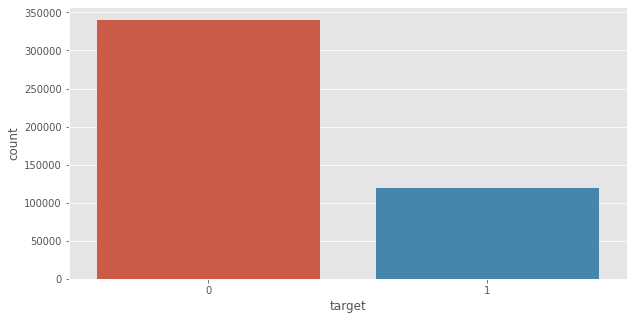

In [16]:
# target_distribution

fig,ax = plt.subplots(figsize=(10,5))

sns.countplot(x = amex_train_label.target)

plt.show()



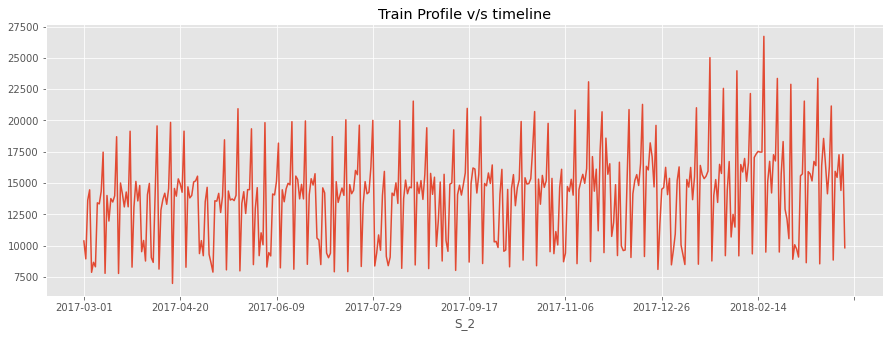

In [17]:
# checking user profile with timeline


fig,ax = plt.subplots(figsize=(15,5))

amex_train.groupby('S_2')['customer_ID'].count().plot()

plt.title('Train Profile v/s timeline')

plt.show()

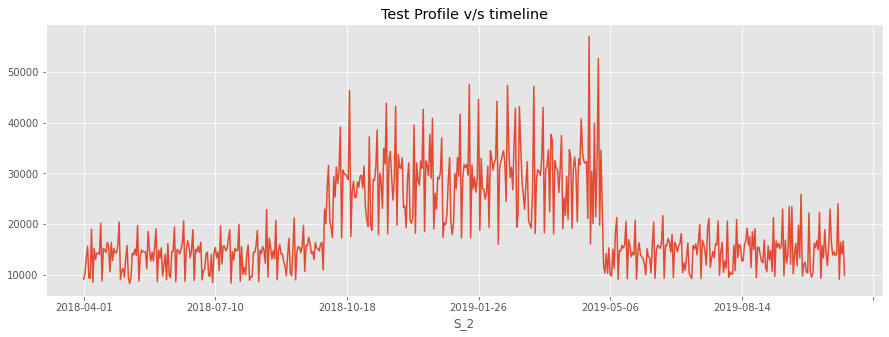

In [18]:
# checking user profile with timeline


fig,ax = plt.subplots(figsize=(15,5))

amex_test.groupby('S_2')['customer_ID'].count().plot()

plt.title('Test Profile v/s timeline')

plt.show()

In [19]:
amex_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float16(177), int8(11), object(2)
memory usage: 2.0+ GB


In [20]:
for col in amex_test.columns:
    if amex_train[col].dtype == 'float16':
        amex_train[col] = amex_train[col].astype('float32').round(decimals=2).astype('float16')
        amex_test[col] = amex_test[col].astype('float32').round(decimals=2).astype('float16')

In [21]:
amex_train = amex_train.groupby('customer_ID').tail(1).reset_index(drop = True)

In [22]:
amex_test = amex_test.groupby('customer_ID').tail(1).reset_index(drop = True)

In [23]:
amex_train = amex_train.merge(amex_train_label,on = 'customer_ID',how = 'left')

In [24]:
def amex_metrics(y_true:pd.DataFrame,y_pred:pd.DataFrame) -> float:
    def top_four(y_true:pd.DataFrame,y_pred:pd.DataFrame) -> float:
        df = (pd.concat([y_true,y_pred],axis='columns').sort_values('prediction',ascending = False))
        df['weights'] = df['target'].apply(lambda x:20 if x==0 else 1)
        four_perc_cutoff = int(0.04*df['weights'].sum())
        df['weight_cumsum'] = df['weights'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <=four_perc_cutoff]
        return (df_cutoff['target'] == 1).sum()/(df['target'] == 1 ).sum()
    
    def weight_gini(y_true:pd.DataFrame,y_pred:pd.DataFrame) -> float:
        df = (pd.concat([y_true,y_pred],axis='columns').sort_values('prediction',ascending = False))
        df['weights'] = df['target'].apply(lambda x:20 if x==0 else 1)
        df['random'] = (df['weights']/df['weights'].sum()).cumsum()
        total_pos = (df['target'] * df['weights']).sum()
        df['cum_pos_found'] = (df['target']*df['weights']).cumsum()
        df['lorentz'] = df['cum_pos_found']/total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weights']
        return df['gini'].sum()
    
    def normalized_weight_gini(y_true:pd.DataFrame,y_pred:pd.DataFrame) -> float:
        y_true_pred= y_true.rename(columns = {'target':'prediction'})
        return weight_gini(y_true,y_pred)/weight_gini(y_true,y_true_pred)
    
    g = normalized_weight_gini(y_true,y_pred)
    d = top_four(y_true,y_pred)
    
    return 0.5 * (g+d)
        

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [26]:
amex_feature = amex_test.columns.to_list()
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

cat_cols = [f"{cf}" for cf in cat_cols]

amex_encode = LabelEncoder()

for cat_feat in cat_cols:
    amex_train[cat_feat] = amex_encode.fit_transform(amex_train[cat_feat])
    amex_test[cat_feat] = amex_encode.fit_transform(amex_test[cat_feat])


In [27]:
train_y = pd.DataFrame(amex_train['target'])
train_x = amex_train.drop('target', axis=1)